In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import pandas as pd 
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

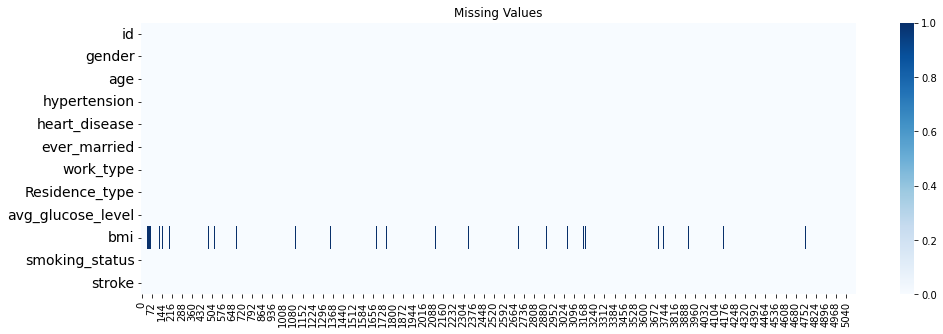

In [7]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

To handle the BMI Missing values, we will use the mean

In [9]:
df.bmi.replace(to_replace=np.nan, value=df.bmi.mean(),inplace=True)
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Data visualization and exploration

<AxesSubplot:>

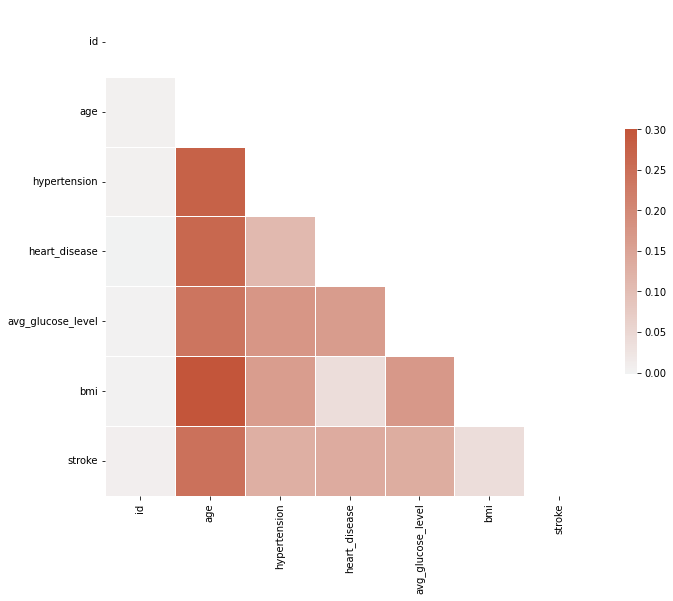

In [10]:
# compute the corr matrix

corr = df.corr()

mask = np.triu(np.ones_like(corr,dtype=bool))

f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={'shrink':.5})

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


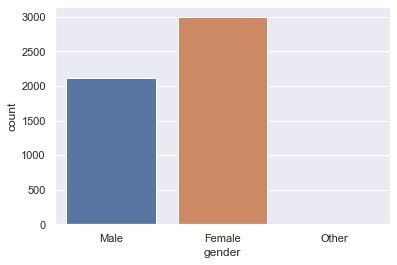

In [11]:
print(df.gender.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='gender')

It seems that we have more females in our dataset than males

Yes    3353
No     1757
Name: ever_married, dtype: int64


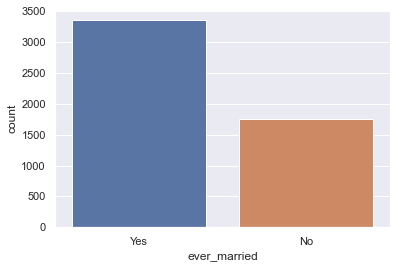

In [12]:
print(df.ever_married.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df, x='ever_married')

We have more married individuals than married

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


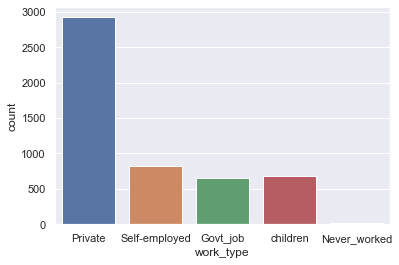

In [14]:
print(df.work_type.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='work_type')

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


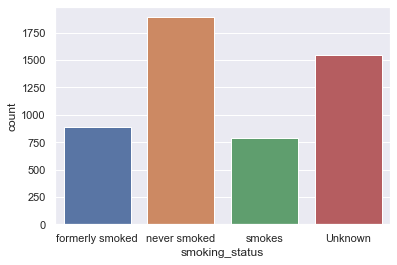

In [15]:
print(df.smoking_status.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='smoking_status')

0    4861
1     249
Name: stroke, dtype: int64


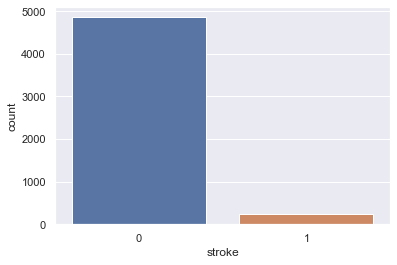

In [16]:
print(df.stroke.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='stroke')

We have a small subsample of people who have had a stroke

(30.0, 330.0)

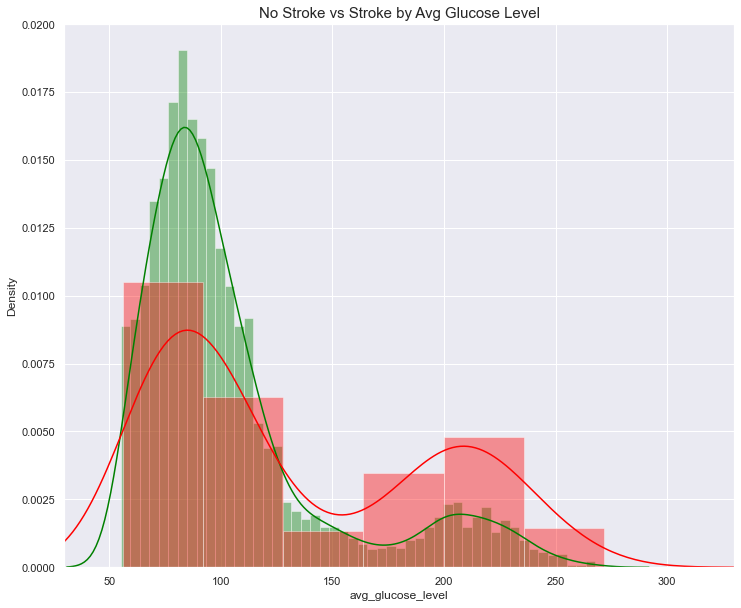

In [18]:
plt.figure(figsize=(12,10))
sns.distplot(df[df['stroke'] == 0]['avg_glucose_level'],color='green')
sns.distplot(df[df['stroke'] == 1]['avg_glucose_level'],color='red')
plt.title('No Stroke vs Stroke by Avg Glucose Level',fontsize=15)
plt.xlim([30,330])

(18.0, 100.0)

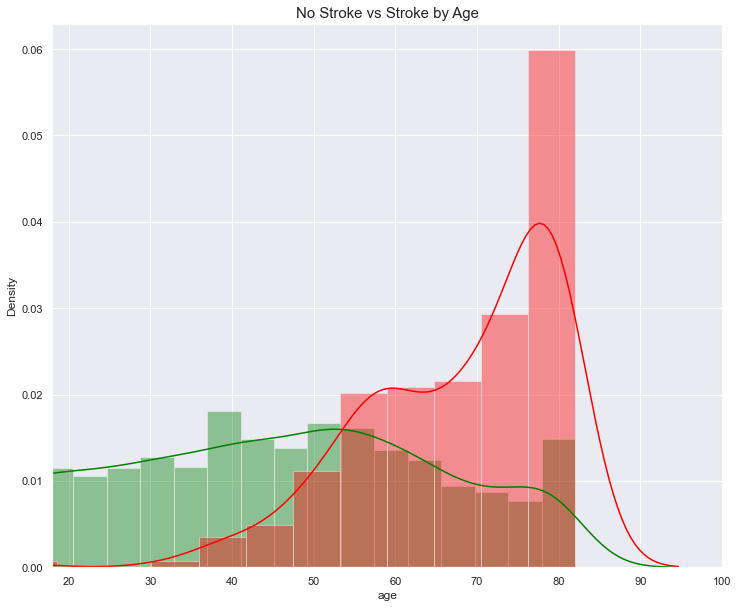

In [19]:
plt.figure(figsize=(12,10))
sns.distplot(df[df['stroke'] == 0]['age'],color='green')
sns.distplot(df[df['stroke'] == 1]['age'],color='red')
plt.title('No Stroke vs Stroke by Age',fontsize=15)
plt.xlim([18,100])

### Data preprocessing for model creation

In [20]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

In [21]:
x = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

print('X Shape', x.shape)
print('Y Shape',y.shape)

X Shape (5110, 10)
Y Shape (5110,)


In [22]:
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0,5,9])],remainder='passthrough')
x = np.array(ct.fit_transform(x))

In [24]:
x[:2, :]

array([[  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ,
         67.        ,   0.        ,   1.        ,   1.        ,
          1.        , 228.69      ,  36.6       ],
       [  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ,
         61.        ,   0.        ,   0.        ,   1.        ,
          0.        , 202.21      ,  28.89323691]])

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

print('Number x_train df',X_train.shape)
print('Number x_test df',X_test.shape)
print('Number y_train df',y_train.shape)
print('Number y_test df',y_test.shape)

Number x_train df (4088, 19)
Number x_test df (1022, 19)
Number y_train df (4088,)
Number y_test df (1022,)


Due to having a underrepresented minority class label (1 = Stroke) we will use [Smote](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [28]:
print('Before OverSampling, counts of label 1: {}'.format(sum(y_train==1)))
print('Before OverSampling, counts of label 0: {} \n'.format(sum(y_train==0)))

Before OverSampling, counts of label 1: 195
Before OverSampling, counts of label 0: 3893 



In [29]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

print('After OverSampling, the shape of train_x: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))

print('After OverSampling, counts of label 1: {}'.format(sum(y_train_res == 1)))
print('After OverSampling, counts of label 0: {}'.format(sum(y_train_res == 0)))

After OverSampling, the shape of train_x: (7786, 19)
After OverSampling, the shape of train_y: (7786,)
After OverSampling, counts of label 1: 3893
After OverSampling, counts of label 0: 3893


Train XGBoost model

In [30]:
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]

In [32]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.57      0.07      0.13        54

    accuracy                           0.95      1022
   macro avg       0.76      0.54      0.55      1022
weighted avg       0.93      0.95      0.93      1022

ROC AUC score: 0.785563973063973
Accuracy Score:  0.9481409001956947


This model preformed very well in predicting if a patient will have a stoke or not

### Saving the model via pkl

In [39]:
import os

os.getcwd()

'/home/jloesch30/school/fall2021/bds_final_proj/notebooks'

In [40]:
import joblib

joblib.dump(classifier, '../output/XGBoost_model.pkl')

['../output/XGBoost_model.pkl']